# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper Functions

In [11]:
# Quadratic Weighted Kappa function
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

# Loading In Data

In [2]:
# load images and labels
train = pd.read_csv('./train.csv')
images = np.load('blindness_images.npy')

In [3]:
images.shape

(3662, 128, 128, 3)

# Train Test Split

In [8]:
X = images
y = train['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

y_train = utils.to_categorical(y_train, 5)
y_test = utils.to_categorical(y_test, 5)

# Transfer Learning Model from Tensorflow, trained by Google

From Tensorflow Hub, we are going to use an EfficientNet model that has been pretrained by Google on the ImageNet-21k dataset. The dataset contains over 14 million images with 21,000 classes. Because this model has been pretrained, I assume that it should perform better as it may have learned underlying patterns existing in images like specific shapes and edges.

[ImageNet](https://www.image-net.org/index.php)

In [10]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(128, 128, 3), trainable=False)


model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(5, activation = 'softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 256,
                 epochs = 100,
                 verbose = 1,
                  callbacks=[early_stop])

Epoch 1/100
11/11 [==============================] - 14s 434ms/step - loss: 2.0470 - accuracy: 0.3536 - val_loss: 1.5061 - val_accuracy: 0.4858
Epoch 2/100
11/11 [==============================] - 2s 192ms/step - loss: 1.2925 - accuracy: 0.5914 - val_loss: 1.1637 - val_accuracy: 0.6485
Epoch 3/100
11/11 [==============================] - 2s 194ms/step - loss: 0.9614 - accuracy: 0.6988 - val_loss: 0.9048 - val_accuracy: 0.6910
Epoch 4/100
11/11 [==============================] - 2s 188ms/step - loss: 0.7941 - accuracy: 0.7185 - val_loss: 0.8410 - val_accuracy: 0.6998
Epoch 5/100
11/11 [==============================] - 2s 189ms/step - loss: 0.7202 - accuracy: 0.7531 - val_loss: 0.8093 - val_accuracy: 0.7238
Epoch 6/100
11/11 [==============================] - 2s 201ms/step - loss: 0.6764 - accuracy: 0.7600 - val_loss: 0.7576 - val_accuracy: 0.7249
Epoch 7/100
11/11 [==============================] - 2s 205ms/step - loss: 0.6344 - accuracy: 0.7749 - val_loss: 0.7350 - val_accuracy: 0.728

In [12]:
preds = model.predict(X_test)
quadratic_weighted_kappa(np.argmax(y_test,axis=1), np.argmax(preds,axis=1))

0.8291453269434985

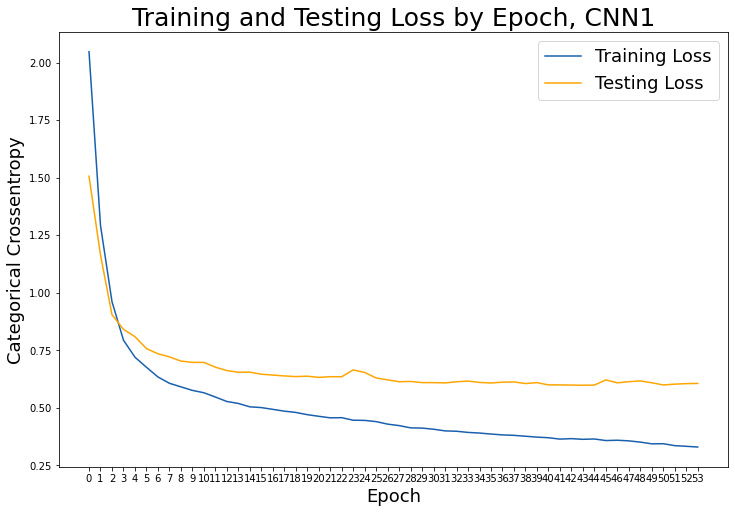

In [15]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch, CNN1', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

The model performs exceptionally better than our previous, built from scratch models. It quickly lowered validation loss and blew away my expectations. I believed it would do well but not this well. Despite it being trained on images unrelated to Diabetic Retinopathy, it performed the best out of all my models.

# Same Model with added Augmentation Layer

In [19]:
tf.random.set_seed(42)
# https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%204%20-%20Lesson%202%20-%20Notebook%20(Cats%20v%20Dogs%20Augmentation).ipynb
data_augmentation2 = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128,128,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)


model_taug = Sequential()

model_taug.add(data_augmentation2)

model_taug.add(pretrained_model_without_top_layer)
model_taug.add(Dense(5, activation = 'softmax'))


model_taug.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

history_taug = model_taug.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 256,
                 epochs = 100,
                 verbose = 1,
                  callbacks=[early_stop])

Epoch 1/100
11/11 [==============================] - 5s 285ms/step - loss: 2.1400 - accuracy: 0.3521 - val_loss: 1.4734 - val_accuracy: 0.4934
Epoch 2/100
11/11 [==============================] - 2s 192ms/step - loss: 1.3227 - accuracy: 0.5852 - val_loss: 1.2649 - val_accuracy: 0.5404
Epoch 3/100
11/11 [==============================] - 2s 186ms/step - loss: 1.0085 - accuracy: 0.6537 - val_loss: 1.0773 - val_accuracy: 0.5742
Epoch 4/100
11/11 [==============================] - 2s 185ms/step - loss: 0.8729 - accuracy: 0.6926 - val_loss: 0.9019 - val_accuracy: 0.6725
Epoch 5/100
11/11 [==============================] - 2s 193ms/step - loss: 0.8012 - accuracy: 0.7185 - val_loss: 0.8309 - val_accuracy: 0.7063
Epoch 6/100
11/11 [==============================] - 2s 194ms/step - loss: 0.7622 - accuracy: 0.7287 - val_loss: 0.7934 - val_accuracy: 0.7151
Epoch 7/100
11/11 [==============================] - 2s 193ms/step - loss: 0.7122 - accuracy: 0.7393 - val_loss: 0.7749 - val_accuracy: 0.7227

In [20]:
preds_taug = model_taug.predict(X_test)
quadratic_weighted_kappa(np.argmax(y_test,axis=1), np.argmax(preds_taug,axis=1))

0.7695884022047552

## Conclusion

With Augmentation, the model performed worse. However the Kappa score is still higher than my other augmented models which goes to show the power of Google's pretrained models and that of Transfer Learning. For those with less resources to classify images, Transfer Learning is a great substitute to making one's own model.